In [1]:
# Round1: Lung Disease Classification - Ensemble of 4 Models

import os
import random
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

# Dataset Paths
base_path = r'C:\Users\gajje\OneDrive\Desktop\Major\Lung_diagnosis_files\Dataset\Dataset\Dataset\round-1'
original_base = os.path.join(base_path, 'Level1', '10%Base')
original_inbox = os.path.join(base_path, 'Level2', 'Inbox')
original_outbox = os.path.join(base_path, 'Level3', 'Outbox')
train_dir = 'temp_dataset/train'
test1_dir = 'temp_dataset/test1'
test2_dir = 'temp_dataset/test2'
test3_dir = 'temp_dataset/test3'

# Clear & Make Folders
for folder in [train_dir, test1_dir, test2_dir, test3_dir]:
    shutil.rmtree(folder, ignore_errors=True)
    os.makedirs(folder, exist_ok=True)

# Function to Split & Copy Images
def split_and_copy(src, dst, split_ratio=1.0, split_type='random'):
    for label in os.listdir(src):
        src_path = os.path.join(src, label)
        dst_path = os.path.join(dst, label)
        os.makedirs(dst_path, exist_ok=True)
        files = [f for f in os.listdir(src_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        files.sort()
        if split_type == 'random':
            files = random.sample(files, int(len(files) * split_ratio))
        elif split_type == 'first_half':
            files = files[:int(len(files) * split_ratio)]
        elif split_type == 'second_half':
            files = files[int(len(files) * split_ratio):]
        for f in files:
            shutil.copy(os.path.join(src_path, f), os.path.join(dst_path, f))

# Dataset Splitting
split_and_copy(original_base, train_dir, 0.9)
split_and_copy(original_base, test1_dir, 0.1)
split_and_copy(original_inbox, test2_dir)
split_and_copy(original_outbox, train_dir, 0.5, 'first_half')
split_and_copy(original_outbox, test3_dir, 0.5, 'second_half')


In [2]:
# Data Generator
img_size = (128, 128)
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test1_data = datagen.flow_from_directory(test1_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test2_data = datagen.flow_from_directory(test2_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test3_data = datagen.flow_from_directory(test3_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
num_classes = train_data.num_classes

# Model Builder for Transfer Learning
def build_model(base_model):
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Custom CNN Model
model_custom = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model_custom.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Transfer Learning Models
model_vgg16 = build_model(VGG16(input_shape=(128,128,3), include_top=False, weights='imagenet'))
model_inception = build_model(InceptionV3(input_shape=(128,128,3), include_top=False, weights='imagenet'))
model_densenet = build_model(DenseNet121(input_shape=(128,128,3), include_top=False, weights='imagenet'))



Found 441 images belonging to 3 classes.
Found 12 images belonging to 3 classes.
Found 534 images belonging to 3 classes.
Found 324 images belonging to 3 classes.


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Train All 4 Models
EPOCHS = 30
all_models = {
    "Custom CNN": model_custom,
    "VGG16": model_vgg16,
    "InceptionV3": model_inception,
    "DenseNet121": model_densenet
}

for name, model in all_models.items():
    print(f"\n--- Training {name} ---")
    model.fit(train_data, epochs=EPOCHS, validation_data=test1_data)



--- Training Custom CNN ---
Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.9141 - loss: 0.2438 - val_accuracy: 0.6667 - val_loss: 0.8925
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.9255 - loss: 0.2288 - val_accuracy: 0.8333 - val_loss: 0.4100
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.9236 - loss: 0.1909 - val_accuracy: 0.8333 - val_loss: 0.3663
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 0.9795 - loss: 0.1083 - val_accuracy: 0.9167 - val_loss: 0.1111
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 299ms/step - accuracy: 0.9926 - loss: 0.0419 - val_accuracy: 1.0000 - val_loss: 0.0582
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 1.0000 - loss: 0.0138 - val_accuracy: 1.0000 - val_loss: 0.0251
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.9986 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 0.0490
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - accuracy: 0.9961 - lo

In [7]:

# Evaluate Individual Models
def evaluate_model(name, model, dataset, dataset_name):
    loss, acc = model.evaluate(dataset, verbose=0)
    print(f"\n{name} - {dataset_name} Accuracy: {acc:.4f}")
    preds = model.predict(dataset)
    y_pred = np.argmax(preds, axis=1)
    y_true = dataset.classes
    print(f"Confusion Matrix for {dataset_name}:\n", confusion_matrix(y_true, y_pred))
    print(f"Classification Report for {dataset_name}:\n", classification_report(
        y_true, y_pred, target_names=list(dataset.class_indices.keys())))

# Ensemble Prediction
def ensemble_predict(models_list, data):
    predictions = [model.predict(data, verbose=0) for model in models_list]
    avg_pred = np.mean(predictions, axis=0)
    return avg_pred

# Evaluate Ensemble
def evaluate_ensemble(name, models_list, dataset, dataset_name):
    avg_preds = ensemble_predict(models_list, dataset)
    y_pred = np.argmax(avg_preds, axis=1)
    y_true = dataset.classes
    acc = np.mean(y_pred == y_true)
    print(f"\n{name} - {dataset_name} Ensemble Accuracy: {acc:.4f}")
    print(f"Confusion Matrix for {dataset_name}:\n", confusion_matrix(y_true, y_pred))
    print(f"Classification Report for {dataset_name}:\n", classification_report(
        y_true, y_pred, target_names=list(dataset.class_indices.keys())))


In [8]:
# Ensemble Evaluation
ensemble_models = [model_custom, model_densenet, model_inception, model_vgg16]
print("\n======== Evaluating Ensemble Model (CustomCNN + DenseNet121 + InceptionV3 + VGG16) ========")
evaluate_ensemble("Ensemble", ensemble_models, test1_data, "Test1 (10%Base)")
evaluate_ensemble("Ensemble", ensemble_models, test2_data, "Test2 (Inbox)")
evaluate_ensemble("Ensemble", ensemble_models, test3_data, "Test3 (Outbox)")


======== Evaluating Ensemble Model (CustomCNN + DenseNet121 + InceptionV3 + VGG16) ========

Ensemble - Test1 (10%Base) Ensemble Accuracy: 1.0000
Confusion Matrix for Test1 (10%Base):
 [[4 0 0]
 [0 4 0]
 [0 0 4]]
Classification Report for Test1 (10%Base):
               precision    recall  f1-score   support

          D0       1.00      1.00      1.00         4
          D1       1.00      1.00      1.00         4
          D2       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12


Ensemble - Test2 (Inbox) Ensemble Accuracy: 0.6442
Confusion Matrix for Test2 (Inbox):
 [[122  24  28]
 [  7  91  82]
 [ 13  36 131]]
Classification Report for Test2 (Inbox):
               precision    recall  f1-score   support

          D0       0.86      0.70      0.77       174
          D1       0.60      0.51      0.55       180
          D2       0.


----- Evaluating Ensemble on Test1 (10%Base) -----
Ensemble Model Accuracy on Test1 (10%Base): 1.0000
Classification Report:
               precision    recall  f1-score   support

          D0       1.00      1.00      1.00         4
          D1       1.00      1.00      1.00         4
          D2       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



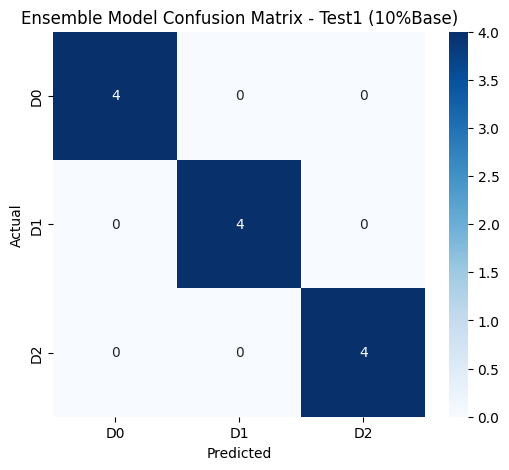


----- Evaluating Ensemble on Test2 (Inbox) -----
Ensemble Model Accuracy on Test2 (Inbox): 0.6442
Classification Report:
               precision    recall  f1-score   support

          D0       0.86      0.70      0.77       174
          D1       0.60      0.51      0.55       180
          D2       0.54      0.73      0.62       180

    accuracy                           0.64       534
   macro avg       0.67      0.64      0.65       534
weighted avg       0.67      0.64      0.65       534



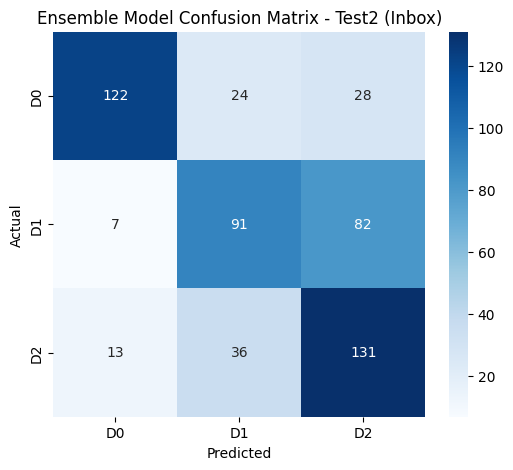


----- Evaluating Ensemble on Test3 (Outbox) -----
Ensemble Model Accuracy on Test3 (Outbox): 0.6605
Classification Report:
               precision    recall  f1-score   support

          D0       0.86      0.60      0.71       126
          D1       0.62      0.56      0.59        72
          D2       0.57      0.78      0.66       126

    accuracy                           0.66       324
   macro avg       0.69      0.65      0.65       324
weighted avg       0.70      0.66      0.66       324



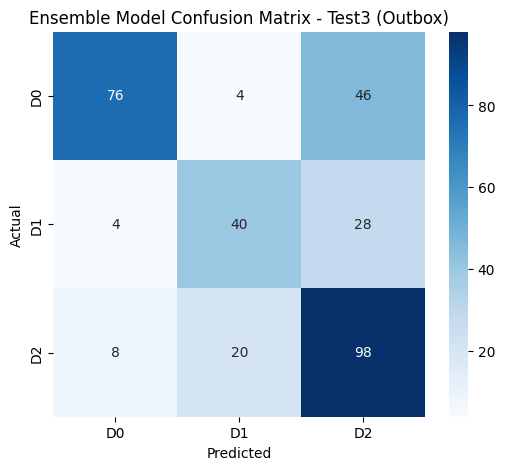

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_conf_matrix(y_true, y_pred, class_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def evaluate_and_plot(name, models, dataset, label):
    print(f"\n----- Evaluating Ensemble on {label} -----")
    avg_preds = ensemble_predict(models, dataset)
    y_pred = np.argmax(avg_preds, axis=1)
    y_true = dataset.classes
    acc = np.mean(y_pred == y_true)
    print(f"{name} Accuracy on {label}: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=list(dataset.class_indices.keys())))

    plot_conf_matrix(y_true, y_pred, class_labels=list(dataset.class_indices.keys()), title=f"{name} Confusion Matrix - {label}")

# Plot confusion matrices for all test sets
evaluate_and_plot("Ensemble Model", ensemble_models, test1_data, "Test1 (10%Base)")
evaluate_and_plot("Ensemble Model", ensemble_models, test2_data, "Test2 (Inbox)")
evaluate_and_plot("Ensemble Model", ensemble_models, test3_data, "Test3 (Outbox)")
